In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn import metrics
import pandas_datareader.data as web 
from time import time
from sklearn.cluster import KMeans

# Get Stock Data

In [3]:
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']
stk_data = web.DataReader(stk_tickers, 'yahoo')
ccy_data = web.DataReader(ccy_tickers, 'fred')
idx_data = web.DataReader(idx_tickers, 'fred')

In [4]:
#Select columns
base = stk_data.loc[:, ('Adj Close', 'MSFT')]
X1 = stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]
X2 = ccy_data
X3 = idx_data
print(X1)
print(X2)
print(X2)

Attributes   Adj Close            
Symbols          GOOGL         IBM
Date                              
2017-10-20   50.253502  122.152084
2017-10-23   49.277000  120.252808
2017-10-24   49.424500  117.486710
2017-10-25   49.573002  115.692879
2017-10-26   49.570999  115.768265
...                ...         ...
2022-10-14   96.559998  120.040001
2022-10-17   99.970001  121.519997
2022-10-18  100.769997  122.940002
2022-10-19   99.629997  122.510002
2022-10-20  100.870003  127.644997

[1259 rows x 2 columns]
            DEXJPUS  DEXUSUK
DATE                        
2017-10-23   113.66   1.3201
2017-10-24   113.92   1.3124
2017-10-25   113.70   1.3252
2017-10-26   113.72   1.3181
2017-10-27   113.82   1.3108
...             ...      ...
2022-10-10      NaN      NaN
2022-10-11   145.55   1.1168
2022-10-12   146.87   1.1096
2022-10-13   147.15   1.1344
2022-10-14   148.46   1.1208

[1300 rows x 2 columns]
            DEXJPUS  DEXUSUK
DATE                        
2017-10-23   113.66   1.3

In [5]:
#Standardized data (X1, X2, X3) with kept index (date)
standard_scaler = preprocessing.StandardScaler()
sX1 = standard_scaler.fit_transform(X1.values)
sX2 = standard_scaler.fit_transform(X2.values)
sX3 = standard_scaler.fit_transform(X3.values)
X1 = pd.DataFrame(index = X1.index,data = sX1,columns=X1.columns)
X2 = pd.DataFrame(index = X2.index,data = sX2,columns=X2.columns)
X3 = pd.DataFrame(index = X3.index,data = sX3,columns=X3.columns)

## Calculate ความแตกต่างของค่า ราคา 'Adj Close', 'MSFT’)ย้อนหลัง backHistory วัน

In [6]:

backHistory = [30, 45, 60, 90, 180, 240] #-> ทดลองหยิบ 3 ค่า 3 รูปแบบ เพื่อดูระยะเวลาการดูค่าข้อมูลย้อนหลงัหลายๆแบบและเปรียบเทียบ MSE
BH1, BH2, BH3 = backHistory[1], backHistory[3], backHistory[4]
return_period = 2
Y = base.shift(-return_period)
X4_BH1 = base.diff( BH1).shift( - BH1)
X4_BH2 = base.diff( BH2).shift( - BH2)
X4_BH3 = base.diff( BH3).shift( - BH3)

X4 = pd.concat([X4_BH1, X4_BH2, X4_BH3], axis=1)
X4.columns = ['MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']
X4 = pd.DataFrame(standard_scaler.fit_transform(X4.values), index = X4.index,columns=X4.columns)

In [7]:
# Forming Dataset
X = pd.concat([X1, X2, X3, X4], axis=1)
dataset = pd.concat([Y, X], axis=1)
dataset.dropna(inplace=True)
dataset.describe()


,"(Adj Close, MSFT)","(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
count,1062.000000,1062.000000,1062.000000,1062.000000,1062.000000,1062.000000,1062.000000,1062.000000,1062.000000,1062.000000,1062.000000
mean,170.246043,-0.180305,-0.208229,-0.351345,0.180731,-0.171819,-0.157852,-0.111275,0.150018,0.133205,0.000458
std,74.517356,0.954893,0.894560,0.323680,0.848681,0.966533,0.982666,1.027426,0.850004,0.917514,0.996036
min,73.884659,-1.111089,-3.298824,-1.132109,-2.495897,-1.708232,-2.489533,-1.348604,-3.551281,-3.647421,-3.380512
25%,103.533525,-0.879508,-0.709610,-0.581247,-0.375414,-0.911670,-0.877691,-0.780619,-0.225654,-0.219805,-0.375193
50%,147.291924,-0.654430,-0.248223,-0.345245,0.101881,-0.596587,-0.520031,-0.365365,0.124673,0.103275,0.095191
75%,221.475185,0.176847,0.291368,-0.129390,0.887274,0.520883,0.458494,0.219334,0.546531,0.602325,0.628783
max,340.882782,2.098358,1.881140,0.433560,1.974076,2.051403,1.997380,7.129384,2.462599,2.187000,2.302308


In [8]:
# Assign X, Y (drop datetime index)
Y = pd.DataFrame(dataset[dataset.columns[0]])
X = pd.DataFrame(dataset[dataset.columns[1:]])
print(Y)
print(X)

             Adj Close
                  MSFT
2017-10-23   73.884659
2017-10-24   74.006805
2017-10-25   78.752029
2017-10-26   78.827217
2017-10-27   78.160065
...                ...
2022-01-27  308.961395
2022-01-28  306.755798
2022-01-31  311.425262
2022-02-01  299.294525
2022-02-02  303.954102

[1062 rows x 1 columns]
            (Adj Close, GOOGL)  (Adj Close, IBM)   DEXJPUS   DEXUSUK  \
2017-10-23           -1.111089          0.426252  0.150358  0.193956   
2017-10-24           -1.106382          0.171241  0.180290  0.072763   
2017-10-25           -1.101642          0.005865  0.154963  0.274227   
2017-10-26           -1.101706          0.012815  0.157266  0.162478   
2017-10-27           -1.034285          0.018373  0.168778  0.047580   
...                        ...               ...       ...       ...   
2022-01-27            1.433451          1.118688  0.358731  0.483560   
2022-01-28            1.572155          1.294675  0.328799  0.533926   
2022-01-31            1.6344

In [9]:
X.corr()

,"(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
"(Adj Close, GOOGL)",1.000000,0.519085,0.180324,0.495622,0.983735,0.955296,0.042151,0.003271,-0.151562,-0.436815
"(Adj Close, IBM)",0.519085,1.000000,0.286229,0.593476,0.539350,0.619171,-0.512233,-0.031685,-0.124006,-0.423540
DEXJPUS,0.180324,0.286229,1.000000,0.097019,0.105035,0.149825,-0.362571,-0.309732,-0.482866,-0.616719
DEXUSUK,0.495622,0.593476,0.097019,1.000000,0.500102,0.544894,-0.297632,0.049336,-0.008681,-0.218409
SP500,0.983735,0.539350,0.105035,0.500102,1.000000,0.983862,-0.005115,-0.026080,-0.130890,-0.357624
DJIA,0.955296,0.619171,0.149825,0.544894,0.983862,1.000000,-0.137353,-0.042716,-0.121364,-0.346036
VIXCLS,0.042151,-0.512233,-0.362571,-0.297632,-0.005115,-0.137353,1.000000,0.282476,0.299302,0.217637
MSFT_3DT,0.003271,-0.031685,-0.309732,0.049336,-0.026080,-0.042716,0.282476,1.000000,0.652356,0.402069
MSFT_6DT,-0.151562,-0.124006,-0.482866,-0.008681,-0.130890,-0.121364,0.299302,0.652356,1.000000,0.712384
MSFT_12DT,-0.436815,-0.423540,-0.616719,-0.218409,-0.357624,-0.346036,0.217637,0.402069,0.712384,1.000000


In [10]:
lower = pd.DataFrame(np.tril(X.corr(),-1),columns = X.columns)
to_drop = [column for column in lower.columns if any(lower[column] > 0.9)]
X.drop(columns=to_drop,inplace=True)
to_drop

[('Adj Close', 'GOOGL'), 'SP500']

In [11]:
X

,"(Adj Close, IBM)",DEXJPUS,DEXUSUK,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
2017-10-23,0.426252,0.150358,0.193956,-1.335744,-1.126136,0.027622,0.047628,-0.148049
2017-10-24,0.171241,0.180290,0.072763,-1.294394,-1.115762,0.026610,0.034463,-0.117031
2017-10-25,0.005865,0.154963,0.274227,-1.322068,-1.107693,0.029100,0.063366,-0.124544
2017-10-26,0.012815,0.157266,0.162478,-1.304473,-1.099625,0.043404,0.079976,-0.101179
2017-10-27,0.018373,0.168778,0.047580,-1.296259,-1.272527,-0.192304,-0.028861,-0.250055
...,...,...,...,...,...,...,...,...
2022-01-27,1.118688,0.358731,0.483560,1.347085,1.112375,0.204870,-1.568893,-2.690554
2022-01-28,1.294675,0.328799,0.533926,1.486241,0.786166,0.051596,-1.983533,-2.674295
2022-01-31,1.212015,0.329950,0.568553,1.586387,0.459956,-0.314000,-2.313248,-2.720882
2022-02-01,1.386224,0.278145,0.672432,1.653756,0.129136,-0.806409,-2.692912,-2.715891


# Train / Test Preparation (try 2 Option)    

In [12]:
from math import ceil, floor
test_size = floor(0.3 * len( X ))
train_size = floor(0.7 * len( X ))
print(f'test size = {test_size}\ntrain size = {train_size}')
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]
# Option #2
# X_train2, X_test2, y_train2, y_test2 = model_selection.train_test_split(X, Y, test_size=0.3, random_state=seed)

test size = 318
train size = 743


# 6.2 GridSearchCV()

In [13]:
# Create Model List
regression = { 'LR': LinearRegression(), 'SVR': SVR(), }
# Create Parameter Dictionary for Linear Regression
fit_intercept = [True, False]
normalize = [True, False]
params_LR = dict( fit_intercept = fit_intercept, normalize = normalize)
print(params_LR)

{'fit_intercept': [True, False], 'normalize': [True, False]}


In [14]:
#Create Parameter Dictionary for SVR
kernel = ['linear', 'rbf', 'poly']
C_list = [10, 100]
ep_list = [0.1, 1, 5]
gamma = [0.01, 0.1]
degree = [2, 3]       #3x2x3x2x2 = 72
params_SVR = dict( kernel = kernel, C = C_list, epsilon = ep_list, gamma = gamma, degree = degree )

In [15]:
for EST in regression:
    model = regression[EST]
    if (EST == 'LR'):
        params = params_LR
    else:
        params = params_SVR

    grid = GridSearchCV( 
    estimator=model,                        #model
    n_jobs = 8,                             #thread ที่ใช้               
    verbose = 10,                           #ความละเอียดในการเปิด log
    cv = 5,                                 #kfold
    scoring = 'neg_mean_squared_error',     #neg mean - mse
    param_grid = params)                    #parameter ที่ใช้กับ model
    grid_result = grid.fit(X_train, Y_train)


Fitting 5 folds for each of 4 candidates, totalling 20 fits


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


Fitting 5 folds for each of 72 candidates, totalling 360 fits


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [16]:
# Show Best Parameters for both models
print('Best params: ',grid_result.best_params_)
print('Best score: ', grid_result.best_score_)

Best params:  {'C': 100, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
Best score:  -828.715260430465


## Show Score for each parameter combination for both model

In [17]:
means   = grid_result.cv_results_['mean_test_score']
stds    = grid_result.cv_results_['std_test_score']
params  = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

-1096.908091 (913.811868) with: {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'linear'}
-1327.106814 (1701.174920) with: {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
-2530.971109 (2532.012710) with: {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'poly'}
-1096.908091 (913.811868) with: {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
-1018.814449 (1131.902399) with: {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
-1467.074657 (1736.486766) with: {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
-1101.728680 (893.456200) with: {'C': 10, 'degree': 2, 'epsilon': 1, 'gamma': 0.01, 'kernel': 'linear'}
-1332.717372 (1702.552165) with: {'C': 10, 'degree': 2, 'epsilon': 1, 'gamma': 0.01, 'kernel': 'rbf'}
-2538.175717 (2545.242717) with: {'C': 10, 'degree': 2, 'epsilon': 1, 'gamma': 0.01, 'kernel': 'poly'}
-1101.728680 (893.456200) with: {'C': 10, 'degree': 2, 'epsilon'

## Display Mean, std, params

# 6.3 RandomizedSearchCV()

In [18]:
# Create Model List
regression = { 'LR': LinearRegression(), 'SVR': SVR()}

In [19]:
# Create Parameter Dictionary for Linear Regression
fit_intercept = [True, False]
normalize = [True, False]
params_LR = dict( fit_intercept = fit_intercept, normalize = normalize)

In [20]:
# Create Parameter Dictionary for SVR
kernel = ['linear', 'rbf', 'poly']
C_list = list(np.linspace(0.1, 150, 5, dtype = float))
ep_list = list(np.linspace(0.1, 1, 5, dtype = float))
gamma = list(np.linspace(0.01, 0.1, 5, dtype = float))
degree = [2, 3]
params_SVR = dict( kernel = kernel, C = C_list, epsilon = ep_list, gamma = gamma, degree = degree )

## Show scatter plot compare y_test vs each model prediction

In [21]:
# import warnings
# warnings.filterwarnings('ignore')

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: 

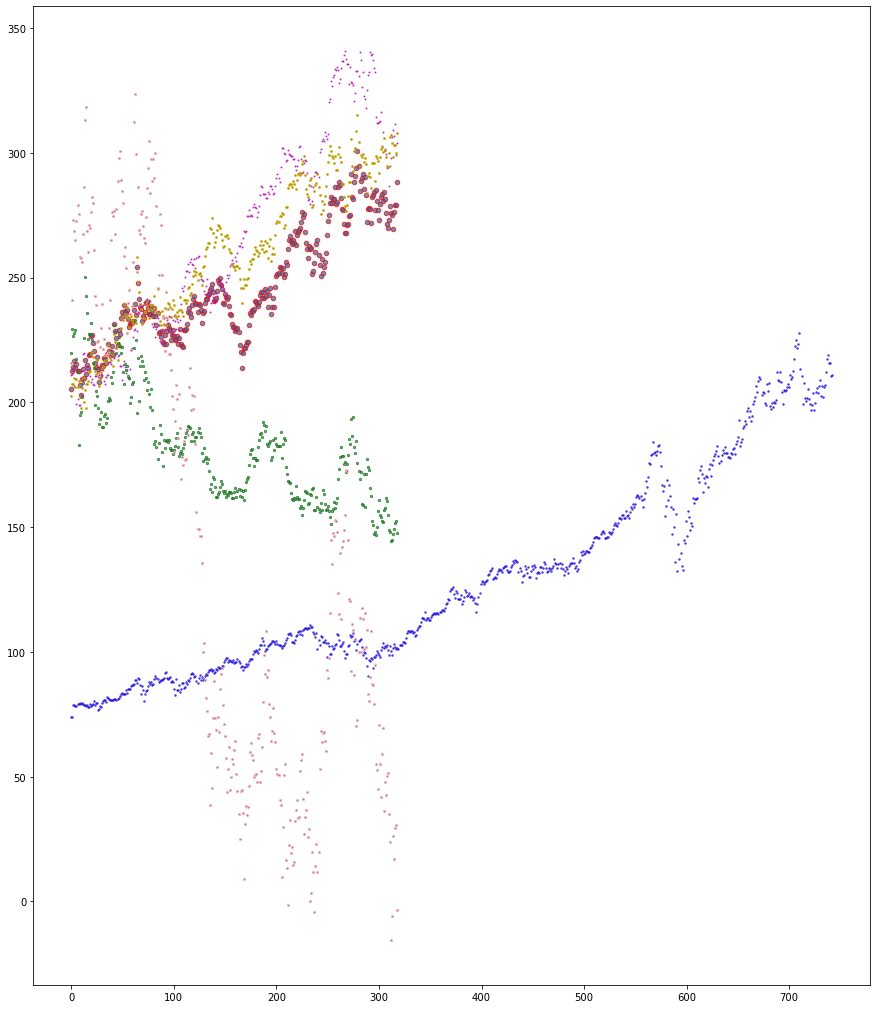

In [22]:
#Best params:  {'C': 100, 'degree': 2, 'epsilon': 5, 'gamma': 0.1, 'kernel': 'rbf'}
n_clusters=np.unique(Y_test)
kmeans = KMeans(n_clusters= n_clusters.size, random_state=0)
clusters_test = kmeans.fit_predict(X_test)
### y_train
n_clusters=np.unique(Y_train)
kmeans = KMeans(n_clusters= n_clusters.size, random_state=0)
clusters_train = kmeans.fit_predict(X_train)
### LM_pred
Model_LM = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
LM_pred = Model_LM.fit(X_train, Y_train).predict(X_test)

#svr 
c_val = 100
svr_lin = SVR(kernel='linear', C=c_val)
svr_rbf = SVR(kernel='rbf', C=c_val, gamma=0.1)
svr_poly = SVR(kernel='poly', C=c_val, degree=2)
SVR_Linear = svr_lin.fit(X_train,Y_train).predict(X_test)   #ค่า Linear Rbf Poly
SVR_Rbf     = svr_rbf.fit(X_train,Y_train).predict(X_test)
SVR_Poly = svr_poly.fit(X_train,Y_train).predict(X_test)


plt.figure(figsize =(15, 18))
plt.scatter(np.arange(len(LM_pred)),    LM_pred,         edgecolors='r',     alpha=0.75,s=20)
plt.scatter(np.arange(len(Y_train)),    Y_train,       edgecolors='b',     alpha=0.75,s=2)
plt.scatter(np.arange(len(Y_test)),     Y_test,         edgecolors='m',     alpha=0.75,s=1)
plt.scatter(np.arange(len(SVR_Linear)), SVR_Linear,    edgecolors='y',     alpha=0.75,s=4)
plt.scatter(np.arange(len(SVR_Rbf)),    SVR_Rbf,         edgecolors='g',     alpha=0.75,s=5)
plt.scatter(np.arange(len(SVR_Poly)),   SVR_Poly,       edgecolors='pink',  alpha=0.75,s=6)

plt.show()

In [23]:
for EST in regression:
    model = regression[EST]
    if (EST == 'LR'):
        params = params_LR
    else:
        params = params_SVR

    grid_rand = RandomizedSearchCV( 
                                    estimator=model, 
                                    n_jobs = 8,
                                    verbose = 10,
                                    cv = 5,
                                    scoring = 'neg_mean_squared_error',
                                    param_distributions = params )
    grid_rand_result = grid_rand.fit(X_train, Y_train)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names 

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [24]:
# Show Best Parameters for both models
print('Best params: ',grid_rand_result.best_params_)
print('Best score: ', grid_rand_result.best_score_)

Best params:  {'kernel': 'linear', 'gamma': 0.01, 'epsilon': 0.1, 'degree': 3, 'C': 112.525}
Best score:  -1082.278385873476


In [25]:
# Show Score for each parameter combination for both model
means = grid_rand_result.cv_results_['mean_test_score']
stds = grid_rand_result.cv_results_['std_test_score']
params = grid_rand_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

-2433.347367 (2471.758019) with: {'kernel': 'poly', 'gamma': 0.01, 'epsilon': 0.1, 'degree': 2, 'C': 37.575}
-2585.224144 (2562.034607) with: {'kernel': 'poly', 'gamma': 0.1, 'epsilon': 0.55, 'degree': 3, 'C': 0.1}
-1082.278386 (895.203845) with: {'kernel': 'linear', 'gamma': 0.01, 'epsilon': 0.1, 'degree': 3, 'C': 112.525}
-1094.736946 (877.667434) with: {'kernel': 'linear', 'gamma': 0.0325, 'epsilon': 1.0, 'degree': 2, 'C': 150.0}
-1800.906739 (2116.591910) with: {'kernel': 'poly', 'gamma': 0.05500000000000001, 'epsilon': 0.325, 'degree': 3, 'C': 75.05}
-1097.445615 (877.650562) with: {'kernel': 'linear', 'gamma': 0.05500000000000001, 'epsilon': 1.0, 'degree': 2, 'C': 37.575}
-1090.428434 (880.759059) with: {'kernel': 'linear', 'gamma': 0.0775, 'epsilon': 0.775, 'degree': 3, 'C': 75.05}
-1089.510478 (881.250546) with: {'kernel': 'linear', 'gamma': 0.1, 'epsilon': 0.775, 'degree': 3, 'C': 150.0}
-1087.650639 (884.552188) with: {'kernel': 'linear', 'gamma': 0.1, 'epsilon': 0.55, 'degre

## Display Mean, std, params

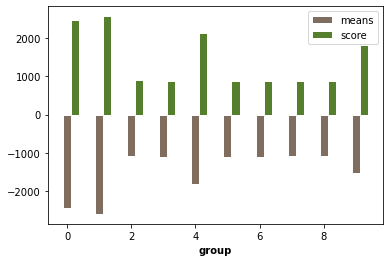

In [26]:
# plt.bar(np.arange(len(means)),means)
# plt.bar(np.arange(len(stds)),stds)
# plt.bar(np.arange(len(params)),params)

# set width of bars
barWidth = 0.25
 
 
# Set position of bar on X axis
r1 = np.arange(len(means))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, means, color='#7f6d5f', width=barWidth, edgecolor='white', label='means')
plt.bar(r2, stds, color='#557f2d', width=barWidth, edgecolor='white', label='score')
 
# Add xticks on the middle of the group bars
plt.xlabel('group', fontweight='bold')
#plt.xticks([r + barWidth for r in range(len(means))], ['A', 'B', 'C', 'D', 'E'])
 
# Create legend & Show graphic
plt.legend()
plt.show()



## Show scatter plot compare y_test vs each model prediction